In [1]:
# скачиваем датасе
!wget https://s3.amazonaws.com/fast-ai-imageclas/imagewoof2-160.tgz
!tar xf imagewoof2-160.tgz

--2021-08-27 20:34:57--  https://s3.amazonaws.com/fast-ai-imageclas/imagewoof2-160.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.16.83
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.16.83|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 92612825 (88M) [application/x-tar]
Saving to: ‘imagewoof2-160.tgz’

imagewoof2-160.tgz  100%[===================>]  88.32M  30.1MB/s    in 2.9s    

2021-08-27 20:35:01 (30.1 MB/s) - ‘imagewoof2-160.tgz’ saved [92612825/92612825]



In [2]:
# нужные импорты
import torch
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.transforms import Resize
from torchvision.transforms import Compose
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch.optim as optim
import os, os.path
from PIL import Image
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

In [3]:
# пути до папок
train_path = '/content/imagewoof2-160/train/'
val_path = '/content/imagewoof2-160/val/'

In [4]:
# из-за того что датасет разделен на папки, можно не писать 
# кастомный датасет, а использовать готовый ImageFolder и
# сразу преобразовывать каждую картинку в тензор и привести к одинаковому размеру.
# Можно было посмотреть средний размер картинки и привести к нему, но в целях экономии ресурсов
# сделаем квадратную картинку по минимальной стороне, которая 160 пикселей, как указано в датасете.

train_folder= ImageFolder(root=train_path, transform=Compose([ToTensor(), Resize((160,160))]))
data_tr = DataLoader(train_folder, batch_size=64, shuffle=True)
val_folder = ImageFolder(root=val_path, transform=Compose([ToTensor(), Resize((160,160))]))
data_val = DataLoader(val_folder, batch_size=64, shuffle=True)

In [5]:
# Для каждого класса посмотрим сколько семплом. 
# Датасет весьма сбалансирован, за исключением класса номер 7.
for i, train_subdir_path in enumerate(os.listdir(train_path)):
  train_subdir_images_path = os.listdir(train_path + train_subdir_path)
  print(f'class {i}, train samples: {len(train_subdir_images_path)}')
print('-------------')
for i, val_subdir_path in enumerate(os.listdir(val_path)):
  val_subdir_images_path = os.listdir(val_path + val_subdir_path)
  print(f'class {i}, val samples: {len(os.listdir(val_path + val_subdir_path))}')

class 0, train samples: 932
class 1, train samples: 921
class 2, train samples: 949
class 3, train samples: 928
class 4, train samples: 949
class 5, train samples: 941
class 6, train samples: 943
class 7, train samples: 580
class 8, train samples: 942
class 9, train samples: 940
-------------
class 0, val samples: 418
class 1, val samples: 429
class 2, val samples: 401
class 3, val samples: 422
class 4, val samples: 401
class 5, val samples: 409
class 6, val samples: 407
class 7, val samples: 224
class 8, val samples: 408
class 9, val samples: 410


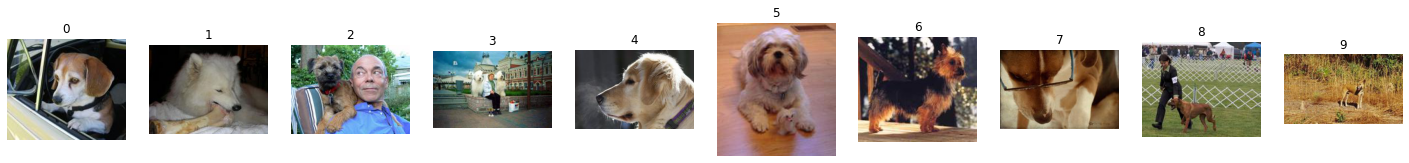

In [6]:
# Датасет не из самых сложных, но и не из самых легких, так как собаки на разных картинках изображены
# по разному и, если углубиться в датасет, то на одной картинке может быть несколько собак.
plt.figure(figsize=(25, 25))
for i, train_subdir_path in enumerate(os.listdir(train_path)):
  train_subdir_images_path = os.listdir(train_path + train_subdir_path)
  plt.subplot(1, 10, i+1)
  image = Image.open(train_path + train_subdir_path + '/' +train_subdir_images_path[0])
  plt.imshow(image)
  plt.title(i)
  plt.axis('off')
plt.show()


In [7]:
# маленькая сеточка для классификации, взята с https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(21904, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)


In [8]:
# https://gist.github.com/aaronpolhamus/964a4411c0906315deb9f4a3723aac57
# для каждой папки по порядку можно найти породу собаки, они идут тут по порядку как описано в исходном датасете
# на fast.ai
classes = ('Australian terrier', 'Border terrier', 'Samoyed', 'Beagle',
           'Shih-Tzu', 'English foxhound', 'Rhodesian ridgeback', 'Dingo', 'Golden retriever', 'Old English sheepdog')

In [9]:
# фукнция для тренировки сети

def train(model, opt, criterion, epochs, data_tr, data_val, classes):
  train_losses = []
  val_losses = []
  for epoch in range(epochs):  
      train_loss = 0.0
      for i, data in tqdm(enumerate(data_tr), total=len(data_tr)):
          inputs, labels = data[0], data[1]
          inputs = inputs.to(device)
          labels = labels.to(device)

          opt.zero_grad()

          outputs = model(inputs)
          loss = criterion(outputs, labels)
          inouts = inputs.detach().cpu()
          labels = labels.detach().cpu()
          loss.backward()
          opt.step()

          train_loss += loss.item() / len(data_tr)
      print(f'train loss: {train_loss}')
      train_losses.append(train_loss)

      val_loss = 0.0
      correct_pred = {classname: 0 for classname in classes}
      total_pred = {classname: 0 for classname in classes}
      accuracy_pred = {classname: 0 for classname in classes}
      with torch.no_grad():
          for data in data_val:
              images, labels = data[0], data[1]
              images = images.to(device)
              outputs = model(images).detach().cpu()
              loss = criterion(outputs, labels)
              val_loss += loss.item() / len(data_val)

              images = images.detach().cpu()
              # возвращает .argmax() для каждого массива первой(которая вторая после батча) оси
              _, predictions = torch.max(outputs, 1) 

              predictions = predictions
              # точность по предсказанию каждой породы
              for label, prediction in zip(labels, predictions):
                  if label == prediction:
                      correct_pred[classes[label]] += 1
                  total_pred[classes[label]] += 1
              for classname, correct_count in correct_pred.items():
                accuracy_pred[classname] += (100 * float(correct_count) / total_pred[classname])/ len(data_val)
      val_losses.append(val_loss)
      print(f'validation loss : {val_loss}')
      print(accuracy_pred)

  print('Finished Training')
  return train_losses, val_losses

In [10]:
# Тут грязно и можно было бы посмотреть как меняется процент определения каждой
# породы. Из наблюдений глазами можно увидеть, что процент классификации в рамках
# определенной породы сильно меняется. Мое предположение, что сетка
# имеет некоторый bias в сторону последнего батча, лайтовенький catastrophic forgetting,
# но я не уверен, потому что в целом моделька улучшает свой результат со временем все-таки.
criterion = nn.CrossEntropyLoss()
optim = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
num_epoch = 20
train_losses, test_losses = train(model, optim, criterion, num_epoch, data_tr, data_val, classes)

  0%|          | 0/142 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|██████████| 142/142 [00:21<00:00,  6.60it/s]


train loss: 2.301552856472176
validation loss : 2.297845259789497
{'Australian terrier': 0.0, 'Border terrier': 0.0, 'Samoyed': 0.0, 'Beagle': 0.0, 'Shih-Tzu': 0.0, 'English foxhound': 0.0, 'Rhodesian ridgeback': 0.0, 'Dingo': 0.0, 'Golden retriever': 0.0, 'Old English sheepdog': 99.99999999999987}


100%|██████████| 142/142 [00:21<00:00,  6.74it/s]


train loss: 2.2992760043748652
validation loss : 2.2939564528003813
{'Australian terrier': 0.0, 'Border terrier': 0.0, 'Samoyed': 0.0, 'Beagle': 0.0, 'Shih-Tzu': 0.0, 'English foxhound': 1.340630608601588, 'Rhodesian ridgeback': 0.0, 'Dingo': 0.0, 'Golden retriever': 0.0, 'Old English sheepdog': 99.99999999999987}


100%|██████████| 142/142 [00:20<00:00,  6.85it/s]


train loss: 2.2938226780421314
validation loss : 2.2904053580376402
{'Australian terrier': 0.0, 'Border terrier': 0.0, 'Samoyed': 0.0, 'Beagle': 0.0, 'Shih-Tzu': 0.0, 'English foxhound': 85.83180637785868, 'Rhodesian ridgeback': 1.2388397447914994, 'Dingo': 0.0, 'Golden retriever': 0.0, 'Old English sheepdog': 24.403575943333678}


100%|██████████| 142/142 [00:20<00:00,  6.80it/s]


train loss: 2.2883163925627596
validation loss : 2.281281436643293
{'Australian terrier': 0.0, 'Border terrier': 0.0, 'Samoyed': 0.0, 'Beagle': 0.0, 'Shih-Tzu': 5.014586761992265, 'English foxhound': 21.66066081410742, 'Rhodesian ridgeback': 70.29225945191364, 'Dingo': 0.0, 'Golden retriever': 21.820811369764836, 'Old English sheepdog': 14.436052143249524}


100%|██████████| 142/142 [00:20<00:00,  6.80it/s]


train loss: 2.270265391175177
validation loss : 2.255776505316457
{'Australian terrier': 54.489933774587584, 'Border terrier': 0.0, 'Samoyed': 0.0, 'Beagle': 0.0, 'Shih-Tzu': 35.962967547231365, 'English foxhound': 4.871067626469254, 'Rhodesian ridgeback': 0.0, 'Dingo': 0.0, 'Golden retriever': 30.64161920518449, 'Old English sheepdog': 0.0}


100%|██████████| 142/142 [00:20<00:00,  6.77it/s]


train loss: 2.2347054649406752
validation loss : 2.1935310171496485
{'Australian terrier': 7.023815333607844, 'Border terrier': 58.26925454932227, 'Samoyed': 21.86527364124548, 'Beagle': 0.0, 'Shih-Tzu': 4.9841233214462255, 'English foxhound': 1.2812581365128952, 'Rhodesian ridgeback': 9.653978931673892, 'Dingo': 23.231152216405594, 'Golden retriever': 50.23587382562306, 'Old English sheepdog': 5.772640532340725}


100%|██████████| 142/142 [00:21<00:00,  6.75it/s]


train loss: 2.180088073434965
validation loss : 2.1575175792940198
{'Australian terrier': 8.005646232752131, 'Border terrier': 60.257692695353406, 'Samoyed': 9.080265522677266, 'Beagle': 0.0, 'Shih-Tzu': 13.948965879953446, 'English foxhound': 0.8071859682332719, 'Rhodesian ridgeback': 28.41703470602484, 'Dingo': 16.064384750147806, 'Golden retriever': 27.698269155215968, 'Old English sheepdog': 28.017885022042766}


100%|██████████| 142/142 [00:21<00:00,  6.73it/s]


train loss: 2.123870983090199
validation loss : 2.0941323138052415
{'Australian terrier': 9.757636732600634, 'Border terrier': 29.312786112406027, 'Samoyed': 20.780117649116203, 'Beagle': 0.6775251622279372, 'Shih-Tzu': 38.08536532326444, 'English foxhound': 5.574539323102222, 'Rhodesian ridgeback': 18.605700316932584, 'Dingo': 24.123340448409206, 'Golden retriever': 71.38221609083838, 'Old English sheepdog': 8.237904838533348}


100%|██████████| 142/142 [00:20<00:00,  6.78it/s]


train loss: 2.0779103930567353
validation loss : 2.075222944059679
{'Australian terrier': 22.605543683924672, 'Border terrier': 36.01548409005969, 'Samoyed': 5.0158902992847345, 'Beagle': 0.12368130063272584, 'Shih-Tzu': 45.287266969611366, 'English foxhound': 25.764975910528197, 'Rhodesian ridgeback': 25.895367810040618, 'Dingo': 13.273555975212746, 'Golden retriever': 49.840244318398184, 'Old English sheepdog': 3.066434899346696}


100%|██████████| 142/142 [00:20<00:00,  6.82it/s]


train loss: 2.043927212836037
validation loss : 2.025468916662278
{'Australian terrier': 7.305827090117176, 'Border terrier': 26.704899320599008, 'Samoyed': 17.250506199370857, 'Beagle': 0.0, 'Shih-Tzu': 2.513019527218175, 'English foxhound': 20.786864551035308, 'Rhodesian ridgeback': 46.675071914380574, 'Dingo': 34.55556065501808, 'Golden retriever': 62.501253981924975, 'Old English sheepdog': 12.173496522251797}


100%|██████████| 142/142 [00:20<00:00,  6.84it/s]


train loss: 2.006397044994462
validation loss : 2.0319967962080434
{'Australian terrier': 7.338025316233782, 'Border terrier': 47.76738079177314, 'Samoyed': 44.40801718258671, 'Beagle': 3.803183484213498, 'Shih-Tzu': 31.705532324459558, 'English foxhound': 5.263766316011689, 'Rhodesian ridgeback': 10.680521681569878, 'Dingo': 9.508459933722131, 'Golden retriever': 76.1322146037899, 'Old English sheepdog': 2.5098241380388817}


100%|██████████| 142/142 [00:20<00:00,  6.86it/s]


train loss: 1.9951787448265184
validation loss : 2.030682067717276
{'Australian terrier': 26.484593091139285, 'Border terrier': 52.292761335586235, 'Samoyed': 16.089040030955854, 'Beagle': 6.2525056570953526, 'Shih-Tzu': 29.381436187795337, 'English foxhound': 33.04246016163559, 'Rhodesian ridgeback': 16.964207069566566, 'Dingo': 24.601693982942024, 'Golden retriever': 26.90056627147438, 'Old English sheepdog': 4.837597665712012}


100%|██████████| 142/142 [00:20<00:00,  6.78it/s]


train loss: 1.969503618461986
validation loss : 1.9863874643079689
{'Australian terrier': 17.52277152082861, 'Border terrier': 9.411198440069544, 'Samoyed': 20.569773815452066, 'Beagle': 6.766678383820982, 'Shih-Tzu': 10.293148225528427, 'English foxhound': 45.81968016879023, 'Rhodesian ridgeback': 25.426466557827204, 'Dingo': 18.507436732011794, 'Golden retriever': 68.11338872183384, 'Old English sheepdog': 15.507980430424608}


100%|██████████| 142/142 [00:20<00:00,  6.79it/s]


train loss: 1.967314927510813
validation loss : 2.0059008329145374
{'Australian terrier': 51.24511475743677, 'Border terrier': 25.499175583657628, 'Samoyed': 6.625888502146041, 'Beagle': 5.694182041079699, 'Shih-Tzu': 28.997443599044196, 'English foxhound': 33.05470950688112, 'Rhodesian ridgeback': 32.71101829367935, 'Dingo': 30.058885796103322, 'Golden retriever': 29.07554668369437, 'Old English sheepdog': 6.478574679835633}


100%|██████████| 142/142 [00:20<00:00,  6.80it/s]


train loss: 1.9506868963510215
validation loss : 2.0455392426060097
{'Australian terrier': 37.02948310803542, 'Border terrier': 12.20428443641481, 'Samoyed': 10.61657489265592, 'Beagle': 15.097196929735198, 'Shih-Tzu': 15.292719427224332, 'English foxhound': 21.97997474104527, 'Rhodesian ridgeback': 26.43148428331145, 'Dingo': 52.05844958253493, 'Golden retriever': 46.581568498612505, 'Old English sheepdog': 22.226432530939718}


100%|██████████| 142/142 [00:20<00:00,  6.84it/s]


train loss: 1.9583391782263637
validation loss : 1.9676331512389642
{'Australian terrier': 22.56062890497122, 'Border terrier': 57.74348457133564, 'Samoyed': 17.668894219209633, 'Beagle': 20.542997465871263, 'Shih-Tzu': 14.08788986983001, 'English foxhound': 18.463847380885348, 'Rhodesian ridgeback': 17.724116723603604, 'Dingo': 35.196217613602116, 'Golden retriever': 49.63378425273892, 'Old English sheepdog': 36.791351598899396}


100%|██████████| 142/142 [00:20<00:00,  6.82it/s]


train loss: 1.9428950464221793
validation loss : 1.9666898654353238
{'Australian terrier': 28.6831672383117, 'Border terrier': 47.39855588637878, 'Samoyed': 10.604213384833692, 'Beagle': 34.69233883864262, 'Shih-Tzu': 24.673021985791415, 'English foxhound': 27.34787568662827, 'Rhodesian ridgeback': 17.032453031701646, 'Dingo': 22.85245992563091, 'Golden retriever': 45.76549668468403, 'Old English sheepdog': 24.79124482290202}


100%|██████████| 142/142 [00:20<00:00,  6.82it/s]


train loss: 1.9020117731161528
validation loss : 1.9898176308601123
{'Australian terrier': 20.47485177383778, 'Border terrier': 27.623217097196495, 'Samoyed': 30.24207430143989, 'Beagle': 42.02737570551225, 'Shih-Tzu': 34.70621604040413, 'English foxhound': 6.027575099868359, 'Rhodesian ridgeback': 27.28217373682986, 'Dingo': 29.73984243567288, 'Golden retriever': 42.03142536104397, 'Old English sheepdog': 17.46400080567376}


100%|██████████| 142/142 [00:20<00:00,  6.80it/s]


train loss: 1.899587476757212
validation loss : 1.9606332471293793
{'Australian terrier': 18.721750893351604, 'Border terrier': 60.721635682650934, 'Samoyed': 21.858150470944736, 'Beagle': 26.0134842955303, 'Shih-Tzu': 34.502638668566924, 'English foxhound': 9.2990856826742, 'Rhodesian ridgeback': 19.80974336289449, 'Dingo': 42.32348459814005, 'Golden retriever': 34.0490591811573, 'Old English sheepdog': 23.738059771703092}


100%|██████████| 142/142 [00:20<00:00,  6.79it/s]


train loss: 1.8806643234172336
validation loss : 2.015629243466162
{'Australian terrier': 23.07342834399247, 'Border terrier': 39.981193072925414, 'Samoyed': 71.48360441738785, 'Beagle': 9.105404952675766, 'Shih-Tzu': 22.60678459942446, 'English foxhound': 39.26659293036053, 'Rhodesian ridgeback': 10.936210996240114, 'Dingo': 22.2028414874281, 'Golden retriever': 29.86909337039544, 'Old English sheepdog': 8.829347263197374}
Finished Training


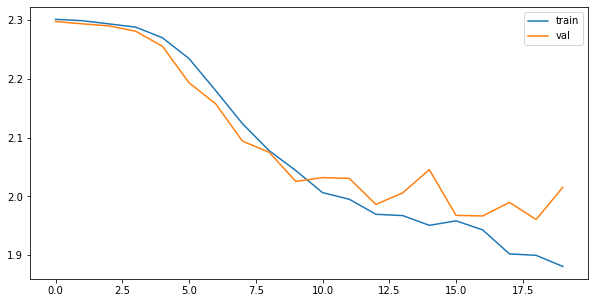

In [16]:
# как видно из графиков, сетка обучается, но под конец имеет тендецию перееобучаться,
# поэтому стоило сохранить эпоху получше, но я этого не сделал.
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label = 'train')
plt.plot(test_losses, label = 'val')
plt.legend()
plt.show()

In [12]:
val_labels = []
val_predictions = []
for data in data_val:
    images, labels = data[0], data[1]
    val_labels.append(labels)
    outputs = model(images.to(device)).detach().cpu()
    _, predictions =torch.max(outputs,1)
    val_predictions.append(predictions)


In [13]:
flat_list_pred = [item for sublist in val_predictions for item in sublist]
flat_list_labels = [item for sublist in val_labels for item in sublist]

(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f5f7248f410>)

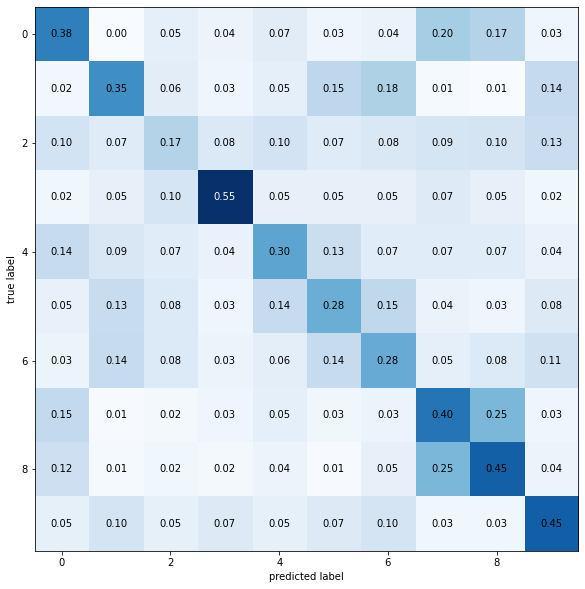

In [14]:
# Из интересного можно посмотреть на confusion matrix,
# чтобы понять какие классы предсказываются хорошие, а какие путаются с другими
# К Примера, 3ий класс собаки предсказывается лучше, чем другие, а 2ой класс собаки 
# практически не имеет отличительных черт для модели.
cm = confusion_matrix(flat_list_pred, flat_list_labels)

plot_confusion_matrix(cm,
                      show_normed=True,
                      show_absolute=False,
                      figsize=(10, 10),)

In [15]:
# В целом, получаем весьма низкий F1-score.
p, r, f1, _ = precision_recall_fscore_support(flat_list_pred,
                                              flat_list_labels,
                                              average='macro',
                                              zero_division=0)

print("Precision:", p)
print("Recall:", r)
print("F1 score:", f1)

Precision: 0.26381920283421767
Recall: 0.3606248465303888
F1 score: 0.2562587076090221


In [ ]:
'''
Из идей как улучшить результат, можно использовать уже 
натренированные сети по типу ResNet, VGG или EfficientNet
и зафайтюнить их на этом датасете.

Чтобы избежать пеереобучения, можно также использовать 
различные аугментации для увеличения тренировочной выборки.

Так же стоит использовать one-hot-encoding для лейблов.
'''